#Preliminary operations

In [28]:
# import main libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [29]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# import data
df_data = pd.read_excel("drive/MyDrive/Progetto Data Mining 2/CODICE PROGETTO/Data Understanding and Preparation/DATASET PREPARED/df_prep_TRAIN.xlsx", index_col="Unnamed: 0")
df_info = pd.read_excel("drive/MyDrive/Progetto Data Mining 2/CODICE PROGETTO/Data Understanding and Preparation/DATASET PREPARED/df_prep_info_TRAIN.xlsx", index_col="Unnamed: 0")

df_data_test = pd.read_excel("drive/MyDrive/Progetto Data Mining 2/CODICE PROGETTO/Data Understanding and Preparation/DATASET PREPARED/df_prep_TEST.xlsx", index_col="Unnamed: 0")
df_info_test = pd.read_excel("drive/MyDrive/Progetto Data Mining 2/CODICE PROGETTO/Data Understanding and Preparation/DATASET PREPARED/df_prep_info_TEST.xlsx", index_col="Unnamed: 0")

In [31]:
df_data.head()

,sum,std,q25,q50,kur,skew,lag1_sum,lag1_kur,lag1_skew,zc_sum,...,mfcc_q95_w4,mfcc_q99_w4,mfcc_kur_w4,sc_std_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_mean_w4,stft_q95_w4,stft_kur_w4
0,0.604904,-1.113727,1.155846,-0.064505,0.746422,1.597947,0.032809,0.526054,0.663058,-1.434221,...,-0.583254,-1.515480,-0.248903,-0.405919,3.146246,-1.505367,0.202942,1.325865,0.035922,3.971428
1,0.565092,-1.067513,1.155846,-0.064505,0.941449,1.648120,0.032809,0.186319,0.920248,-1.261744,...,-0.816861,-0.814428,0.141589,-0.408215,-0.236257,-0.713717,-0.120760,0.953175,0.035922,-0.381447
2,0.610689,-0.946842,1.891250,-0.064505,1.011526,1.770978,-0.885806,0.614675,0.111653,-1.673729,...,-0.514856,-1.120598,-0.095555,-0.227969,2.741296,-1.301205,-0.232259,1.008646,0.035922,2.877028
3,0.598277,-0.975367,1.155846,-0.064505,1.569306,1.970460,-0.696296,0.565900,0.856282,-1.352954,...,-0.059808,-0.706300,-0.404156,-0.535901,-0.469754,-0.612675,-0.537815,0.888896,0.035922,-0.307128
4,0.595865,-1.306279,1.155846,-0.064505,0.488840,1.426924,-0.696296,0.269613,0.151788,-1.499722,...,-0.503638,-0.784317,0.042496,-0.230801,0.600646,-0.701060,0.212217,0.950638,0.035922,1.797345


In [32]:
# concatenate info and data dataframes
df_prep = pd.concat([df_info, df_data], axis=1)
df_test_prep = pd.concat([df_info_test, df_data_test], axis=1)

# Isolation Forest

In [33]:
# get values from dataframes
X = df_prep.loc[:, "sum":].values
X_test = df_test_prep.loc[:, "sum":].values

In [34]:
# define IsolationForest
clf = IsolationForest(
    random_state=0, 
    n_estimators=10000
)

# fit IsolationForest
clf.fit(X)

# get outliers for training- and test-set
outliers = clf.predict(X)
outliers_test = clf.predict(X_test)

In [35]:
# get outliers number for training-set
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  50, 1778]))

In [36]:
outliers_i = []

# get outliers index for training-set 
for i, b in enumerate(outliers):
  if b == -1:
    outliers_i.append(i)

assert len(outliers_i) == 50

In [37]:
# drop outliers from training-set
df_prep.drop(outliers_i, axis=0, inplace=True)

In [38]:
# get outliers number for test-set
np.unique(outliers_test, return_counts=True)

(array([-1,  1]), array([ 22, 602]))

In [39]:
# reset training datafrae index
df_prep.reset_index(inplace=True)
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Columns: 116 entries, index to stft_kur_w4
dtypes: float64(106), int64(3), object(7)
memory usage: 1.6+ MB


In [40]:
outliers_i = []

# get outliers index for training-set 
for i, b in enumerate(outliers_test):
  if b == -1:
    outliers_i.append(i)

assert len(outliers_i) == 22

In [41]:
# drop outliers from training-set
df_test_prep.drop(outliers_i, axis=0, inplace=True)

In [42]:
# reset test dataframe index
df_test_prep.reset_index(inplace=True)
df_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Columns: 116 entries, index to stft_kur_w4
dtypes: float64(106), int64(3), object(7)
memory usage: 545.7+ KB


#Interquartile range outliers removal

In [43]:
# define percentiles for removal of outliers
percentile25 = df_prep.loc[:, "sum":].apply(lambda x: x.quantile(0.25))
percentile75 = df_prep.loc[:, "sum":].apply(lambda x: x.quantile(0.75))
# define interquartile range (iqr)
iqr = percentile75 - percentile25

# define limits for the percentiles
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [44]:
# get outliers
df_data_outliers = df_prep.loc[:, "sum":][(df_prep.loc[:, "sum":] < upper_limit) & (df_prep.loc[:, "sum":] > lower_limit)]
df_prep.loc[:, "sum":] = df_data_outliers

# replace outliers with the group median
for col in df_prep.loc[:, "sum":].columns:
    df_prep[col] = df_prep[col].fillna(
        value=df_prep.groupby(["emotional_intensity", "statement", "repetition", "sex"])[col].transform(
            "median"
            )
        )

In [45]:
# get outliers
df_data_outliers = df_test_prep.loc[:, "sum":][(df_test_prep.loc[:, "sum":] < upper_limit) & (df_test_prep.loc[:, "sum":] > lower_limit)]
df_test_prep.loc[:, "sum":] = df_data_outliers

# replace outliers with the group median
for col in df_test_prep.loc[:, "sum":].columns:
    df_test_prep[col] = df_test_prep[col].fillna(
        value=df_test_prep.groupby(["emotional_intensity", "statement", "repetition", "sex"])[col].transform(
            "median"
            )
        )

In [46]:
# rescale data with standard scaler
std_scaler = StandardScaler()

std_scaler.fit(df_prep.loc[:, "sum":])

df_data_scaled = std_scaler.transform(df_prep.loc[:, "sum":])
df_prep.loc[:, "sum":] = df_data_scaled

df_data_test_scaled = std_scaler.transform(df_test_prep.loc[:, "sum":])
df_test_prep.loc[:, "sum":] = df_data_test_scaled

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


##Drop useless columns

In [47]:
# find and remove useless columns
cols_to_drop = df_prep.columns[df_prep.isna().any()].tolist()

df_prep.drop(cols_to_drop, axis=1, inplace=True)
df_test_prep.drop(cols_to_drop, axis=1, inplace=True)

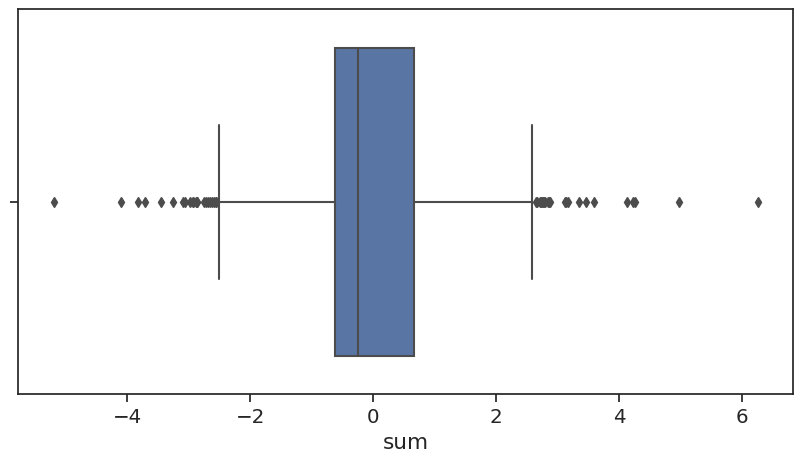

In [48]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.3)

sns.boxplot(x=df_data["sum"])
plt.savefig("sum_with_outliers.pdf", format="pdf")

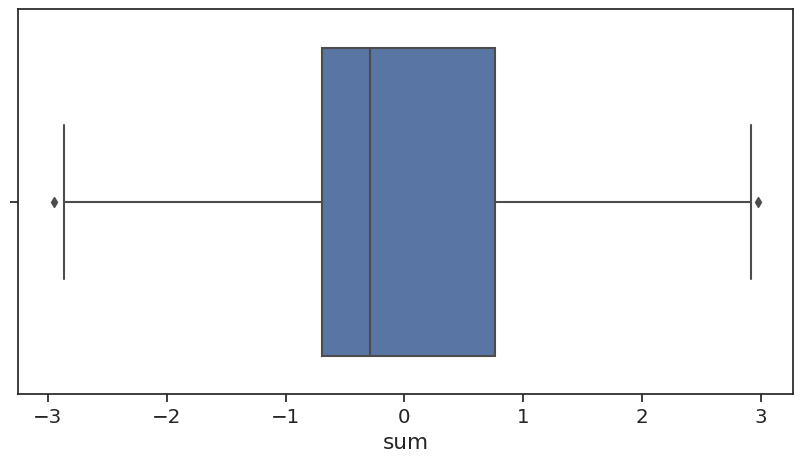

In [49]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.3)

sns.boxplot(x=df_prep["sum"])
plt.savefig("sum_without_outliers.pdf", format="pdf")

#Export files

In [50]:
df_prep.drop("index", axis=1, inplace=True)
df_test_prep.drop("index", axis=1, inplace=True)

##Export data

In [51]:
df_prep.loc[:, "sum":].to_excel("df_prep_TRAIN.xlsx",
             sheet_name='Prepared Data Set') 

In [52]:
df_test_prep.loc[:, "sum":].to_excel("df_prep_TEST.xlsx",
             sheet_name='Prepared Data Set') 

##Export Info

In [53]:
df_prep.loc[:, :"frame_count"].to_excel("df_prep_info_TRAIN.xlsx",
             sheet_name='Prepared Data Set')

In [54]:
df_test_prep.loc[:, :"frame_count"].to_excel("df_prep_info_TEST.xlsx",
             sheet_name='Prepared Data Set') 